In [31]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [33]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 1)
    optimizer.step(closure)  

In [34]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
global Phi_0

V = lambda r: -(Z*e**2)/r
Phi_aux = lambda r: r*torch.exp(-beta*r) * model.forward(r)
Phi_t = lambda r: Phi_aux(r) - Phi_0*torch.trapezoid(Phi_0[100:]*Phi_aux(r)[100:], r[100:],dim=0)

In [35]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)    
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=0 to 6

    prom = Phi.size()[0]
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [36]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)

In [37]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])

Phi_0 = torch.Tensor(np.loadtxt("file.txt")).reshape(200,1)
print(torch.sqrt(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0)))
#Phi_0 = Phi_0/torch.sqrt(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0))
Phi_0 = Phi_0.detach()
print(Phi_0.shape)

tensor([0.2745])
torch.Size([200, 1])


In [38]:
model = NeuralNetwork()
initialize_weights(model)
print(Phi_t(R_train))
loss_fn(R_train)

tensor([[-9.2641e+05],
        [-8.1291e+05],
        [-7.1325e+05],
        [-6.2574e+05],
        [-5.4892e+05],
        [-4.8147e+05],
        [-4.2227e+05],
        [-3.7030e+05],
        [-3.2470e+05],
        [-2.8468e+05],
        [-2.4956e+05],
        [-2.1875e+05],
        [-1.9172e+05],
        [-1.6801e+05],
        [-1.4721e+05],
        [-1.2897e+05],
        [-1.1297e+05],
        [-9.8950e+04],
        [-8.6654e+04],
        [-7.5875e+04],
        [-6.6427e+04],
        [-5.8147e+04],
        [-5.0891e+04],
        [-4.4533e+04],
        [-3.8964e+04],
        [-3.4085e+04],
        [-2.9812e+04],
        [-2.6070e+04],
        [-2.2793e+04],
        [-1.9925e+04],
        [-1.7414e+04],
        [-1.5217e+04],
        [-1.3294e+04],
        [-1.1611e+04],
        [-1.0140e+04],
        [-8.8527e+03],
        [-7.7271e+03],
        [-6.7431e+03],
        [-5.8829e+03],
        [-5.1312e+03],
        [-4.4743e+03],
        [-3.9005e+03],
        [-3.3992e+03],
        [-2

tensor([1.7843e+10], grad_fn=<DivBackward0>)

(200,)


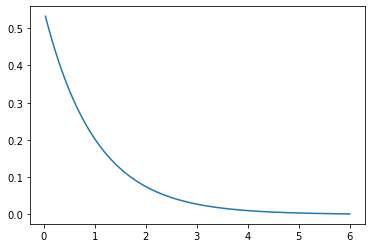

In [39]:
print(np.linspace(lower_r, upper_r, steps).shape)
plt.plot(np.linspace(lower_r, upper_r, steps)[100:],np.divide(Phi_0.detach().numpy()[100:],np.linspace(lower_r, upper_r, steps).reshape(200,1)[100:]))

In [40]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 500
lr1 = 4e-1
lr2 = 4e-2 
Phis_t = []
Es = []
lss = []
epochs = []



start = time.time()

model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr1)
for t in range(epoch):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)    
'''optimizer = torch.optim.Adam(model.parameters(), lr=lr2)
for t in range(int(epoch/2)+1,epoch):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)'''
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

end = time.time()
print(end - start)

Epoch 1
 ---------------------- loss: tensor([1.7017e+10], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([1.9238e+10], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([1.7828e+10], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([1.7183e+10], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([1.6138e+10], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([1.4910e+10], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([1.3146e+10], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([1.1043e+10], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([8.6934e+09], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([7.0285e+09], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([5.6359e+09], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([3.9358e+09], grad_fn=<DivBackward0>)
E

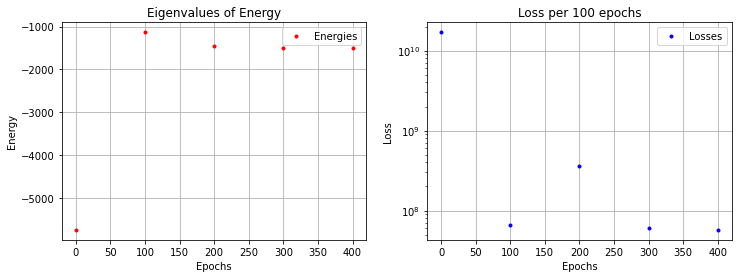

In [41]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 5

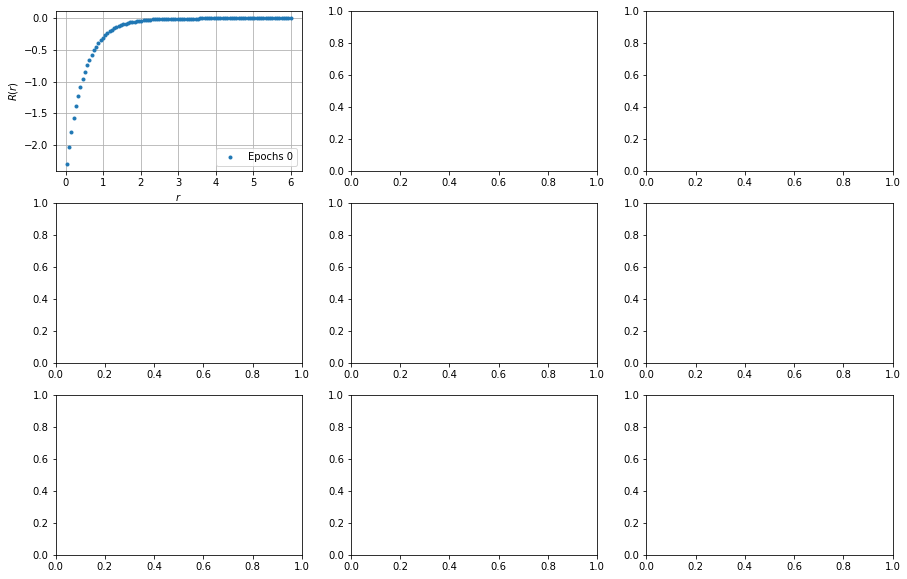

In [42]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[50*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[50*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.tight_layout()
plt.show()  

In [ ]:
Es